<div align = 'center'> Second Pipeline: 
    
<div align = 'center'> Macbeth K. Matibe
    
<div align = 'center'> Minerva University
    
<div align = 'center'> CS156: Finding Patterns in Data with Machine Learning
    
<div align = 'center'> Prof. Watson
    
<div align = 'center'> April 11, 2023

## Motivation behind the data, what's the story here?

In the first pipeline, I classified data from just my mom and dad. But just imagine, what if I could classify every incoming text within my entire phonebook? Or just from close family and friends, in a bid to not sound too ambitious. What if I could build a completely secure fraud protection mechanism? Well, that would require a lot of work, but there is a saying in Swahili that goes, "Haba haba hujaza kibaba." I don't know the exact accurate translation, but it roughly means, "Little by little fills the measure." The closest English proverb is "Slow and steady wins the race." So I added a few more people to my text database. My friends, Irynn and Rasugu, my partner Lee and my grandma. This provides a variety of data summing up to 6 different labels to try and classify. 


So, while I can't build a whole model to protect unsuspecting Kenyans against fraudulent attacks by Mpesa and mobile banking fraudsters, I can add a little more data from my friends and other family members, like my grandma, who might be especially susceptible to fraud, seeing as she dislikes everything technology-related. In addition, we can try another model to classify the different authors of each text.


In the first pipeline, I used the Naive Bayes classifier, which performed pretty well in classifying texts from my mom and dad. Can it perform equally well for extended data with more targets? Will the new model, which I will keep as a surprise for now, perform better? Will one be faster than the other? Remember, we need a model that is not only accurate but also pretty quick. In my future world, a model that can quickly scan a text and change the font color to red if we suspect it is from a fraudster thus prompting the receiver to take precautionary measures such as calling the sender to confirm that they wrote the message that could involve asking for sensitive information or money or forwarding the fraudelent caller's number to the relevant authorities. 

## Explaining the data & Ethics

One point of concern was data privacy, so I talked to everyone involved beforehand and obtained their consent to use their texts in my assignment, provided that I omitted sensitive information.

The data collection process involved exporting all their chats into PDF files and copying them to a Google Sheets spreadsheet. Each exported chat had its own spreadsheet. However, while working on this pipeline, I realized that using ChatGPT to extract the data and remove the rows that had messages from me was quite hectic, and I actually went through a lot of unnecessary trouble the last time to use AI to clean the data for me. In addition, for some reason, ChatGPT kept returning made-up texts, which could greatly affect the accuracy scores for the model.

## Loading the Data to Python

To use the data in Python, I downloaded the spreadsheets as .csv files, which I loaded into Python using the Pandas library as a Pandas DataFrame (Matibe, 2023). Since I didn't clean the data before loading it into Python, my data was a jumbled mess of timestamps, sender labels in the text column, and messages from me, as shown below from one of the .csv files. The only clean data was the original spreadsheet used in the First Pipeline that contained texts from my mom and dad. We can't use the data like this :( Additionally, all the data was in different CSV files, and therefore part of loading them into Python involved combining them into one DataFrame and shuffling the data to make it stochastic and prevent feeding the model with a chronological order of the texts (Matibe, 2023).

In [43]:
import pandas as pd

# Load the data from the 6 CSV files --> 7 labels since mom and dad are combined on 1 csv file
mom_dad = pd.read_csv('texts_mom_dad.csv', header=None)
grandma = pd.read_csv('grandma_texts.csv', header=None)
Irynn = pd.read_csv('Irynn_texts.csv', header=None)
Rasugu = pd.read_csv('Rasugu_texts.csv', header=None)
Lee = pd.read_csv('Lee_texts.csv', header=None)

grandma.head(7) # view first 7 data points of grandma's dataframe (observe the timestamps, name labels and texts from Macbeth in the mess)


,0,1
0,text,label
1,"[01/01/23, 13:59:16] MacBeth: Happy New Year G...",grandma
2,"[01/01/23, 13:59:27] MacBeth: And HAPPY BIRTHDAY",grandma
3,"[01/01/23, 13:59:30] MacBeth:",grandma
4,"[01/01/23, 15:13:28] Grandma: Happy new year 2...",grandma
5,"[01/01/23, 15:14:00] Grandma: Thanks for wishi...",grandma
6,"[01/01/23, 15:41:27] MacBeth: ♥️♥️♥️♥️",grandma


In [44]:
# Combining into 1 dataframe
combined_data = pd.concat([mom_dad, grandma, Irynn, Rasugu, Lee], ignore_index=True)

# Shuffling the data
# Observe - Labels are mixed up, an you each label atleast once from the sampled data?
texts_data = combined_data.sample(frac = 1, random_state = 28).reset_index(drop=True) #28 is just a lucky number, this can be changed to get a different shuffle
texts_data.columns = ['text', 'label'] #put in the columns again

print('In this initial stage I have', len(texts_data), 'data points')

texts_data.head(11) # view first 10 data points of the combined, shuffled dataframe

In this initial stage I have 1919 data points


,text,label
0,"[02/04/23, 12:24:20] MacBeth: Nimeona",Lee
1,"[06/03/23, 23:36:02] Mummy 🖤: Sawa. Goodnight ...",mom
2,"[30/01/23, 19:44:00] Grandma: I went to the su...",grandma
3,"[01/04/23, 20:55:13] Lee Mwangi: Meanwhile do ...",Lee
4,"[12/03/23, 23:44:16] MacBeth: I can read you l...",Rasugu
5,"[01/04/23, 20:57:29] MacBeth: 🙂i will.. 🤭",Lee
6,"‎[01/02/23, 15:30:24] Grandma: ‎image omitted",grandma
7,"[02/04/23, 00:44:27] MacBeth: You already knew...",Lee
8,"‎[28/02/23, 19:37:54] Mummy 🖤: ‎image omitted",mom
9,"[05/04/23, 17:22:07] MacBeth: 😂😂 now I sound l...",Lee


## Cleaning, pre-processing, exploratory data analysis and feature engineering. 

**Cleaning and Pre-processing** 


When exporting the data from WhatsApp, it exports everything, including texts I sent, which are not needed in this classification task, since my writing style is not what we are analyzing here, but rather the authors of the various texts. Therefore, I need to remove texts that I sent. Since the sender labels are included, this makes it easy, as all I have to do is remove any rows where the text column contains the name 'MacBeth'. This should drop about half of the data points since texting is a back-and-forth game, meaning half of the texts were mine, and those are the ones that we are dropping. I also need to drop rows that have the phrase 'image omitted' in the text column because this isn't an actual text but a placeholder for when the chat was exported and a sender had sent a picture.

For use in our classification task, we are only interested in the specific texts, so the timestamps and sender labels don't matter much. Therefore, part of the cleaning process involves removing the timestamps and sender labels after removing the texts that I sent. I did this by applying a lambda function to the second column of the DataFrame to extract only the text from each row, which is achieved by splitting the row string data at the ':' separator and selecting the last element.

These two steps are done in the following code cells.

In [52]:
# drop rows where the sender is MacBeth
texts_data = texts_data[~texts_data['text'].str.contains('MacBeth')]

# drop rows where the text says image omitted because the sender sent an image 
texts_data = texts_data[~texts_data['text'].str.contains('image omitted')]

# There was a shuffle and some of the column heads were mixed in with the data so removing those as well
texts_data = texts_data[~texts_data['label'].str.contains('label')]

# reset the index
texts_data = texts_data.reset_index(drop=True)

# sanity check
print('In this cleaning stage I now have', len(texts_data), 'data points') 

# view first 10 data points of the cleaned data
# Observe --> We no longer have texts sent by MacBeth
texts_data.head(11) 

In this cleaning stage I now have 982 data points


,text,label
0,Sawa. Goodnight dear.,mom
1,I went to the supermarket to buy some sufurias...,grandma
2,Meanwhile do sth to cheer up,Lee
3,Was driving to see grandma... just arrived,mom
4,Yea... it's actually the simple things in life...,mom
5,Weh... bado tu ni expensive .,mom
6,Na... if you take the train? Will it reduce th...,mom
7,unakuona na tunakusikia; although hazy,mom
8,You can’t change my mind,Irynn
9,And i have a pte tomorrow,Lee


In [53]:
# extract only the text from each row
texts_data['text'] = texts_data['text'].apply(lambda x: x.split(': ')[-1])

# sanity check --> should remain the same from the step above
print('In this cleaning stage I now have', len(texts_data), 'data points') 

# view first 10 data points of the cleaned data
# Observe --> timestamps and sender labels have been dropped from the text column
texts_data.head(11) 

In this cleaning stage I now have 982 data points


,text,label
0,Sawa. Goodnight dear.,mom
1,I went to the supermarket to buy some sufurias...,grandma
2,Meanwhile do sth to cheer up,Lee
3,Was driving to see grandma... just arrived,mom
4,Yea... it's actually the simple things in life...,mom
5,Weh... bado tu ni expensive .,mom
6,Na... if you take the train? Will it reduce th...,mom
7,unakuona na tunakusikia; although hazy,mom
8,You can’t change my mind,Irynn
9,And i have a pte tomorrow,Lee


 performed further preprocessing steps such as lowercasing the texts column, removing punctuation and numbers, tokenization, and lemmatization (I haven't explained the meaning and importance of each, as this was extensively covered in the First Pipeline).

Additionally, I had to remove emojis since I didn't use ChatGPT this time but instead loaded the raw data as it is into Python.

After performing these steps, I realized that some rows were left empty since some of the texts were just emojis, and when removed, the value is just null. Therefore, the final preprocessing step was to remove any null values.

In [63]:
import string
import nltk
import re

# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# lowercasing texts
texts_data['text'] = texts_data['text'].str.lower()

# removing punctuation and numbers
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation + string.digits))

texts_data['text'] = texts_data['text'].apply(remove_punctuation)

# tokenization and lemmatization
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

texts_data['text'] = texts_data['text'].apply(lemmatize)

# remove emojis (Got this from StackOverflow)
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

texts_data['text'] = texts_data['text'].apply(remove_emojis)

# drop null values
texts_data = texts_data.dropna(subset = ['text'])

# sanity check --> should be fewer of remain the same from the step above
print('In this cleaning stage I now have', len(texts_data), 'data points') 

# view first 10 data points of the cleaned data
texts_data.head(11) 

In this cleaning stage I now have 982 data points


,text,label
0,sawa goodnight dear,mom
1,i went to the supermarket to buy some sufurias...,grandma
2,meanwhile do sth to cheer up,Lee
3,wa driving to see grandma just arrived,mom
4,yea it actually the simple thing in life that ...,mom
5,weh bado tu ni expensive,mom
6,na if you take the train will it reduce the ex...,mom
7,unakuona na tunakusikia although hazy,mom
8,you can ’ t change my mind,Irynn
9,and i have a pte tomorrow,Lee


The data is now clean and correctly formatted for any exploratory analysis and feature engineering. 

**Exploratory data analysis**

I was curious to find out which of my chosen family and friends text me the most, so I created a histogram of the number of texts from each of them, which represents the distribution of labels. I also created a distribution of text lengths to see how much it was affected by the new data from last time by comparing it with an average text length of 5.38 words from the First Pipeline, which only contained texts from my mom and dad.

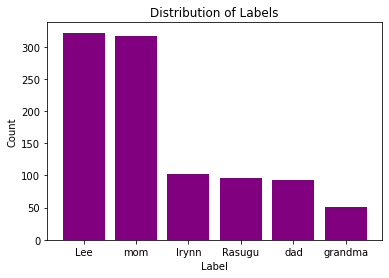

In [64]:
# Visualization of the distribution of labels. (Matibe, 2023)
# Code is same from last time since the exploratory analysis being done is the same just with more data
import matplotlib.pyplot as plt

labels = texts_data['label'].value_counts()

plt.figure()
plt.bar(labels.index, labels.values, color = 'purple')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

From the distribution above, it seems that I text Lee and my mom the most, which doesn't come as a shock to me. Lee is literally my best friend, and my mom is, well, my mom, and I tell her everything. However, it seems that I need to text my grandma and dad more since they have the fewest texts of the lot. This helped me identify a bias I had last time during data collection since the label distribution for my mom and dad was the same, as I extracted an almost equal number of texts for both. However, in this second pipeline, I extracted all the texts for each sender for the same time period.

The texts have an average length of 5.35 words


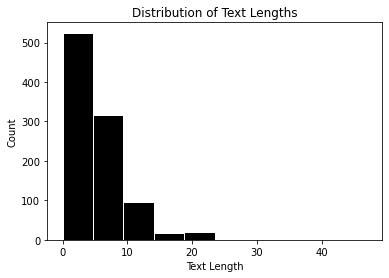

In [65]:
import numpy as np

# text lengths
text_lengths = texts_data['text'].apply(lambda x: len(x.split()))

print('The texts have an average length of', round(np.mean(text_lengths), 2), 'words')

# Plot a histogram of the text lengths
plt.hist(text_lengths, color = 'black', edgecolor = 'white')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

From the distribution above, the distribution of text lengths had a few more outliers this time compared to last time, but overall, the average length remained the same at approximately 5 words. Last time, we had an average length of 5.38 words, and this time it is 5.35 words.

**Feature engineering**

This subsection involves feature engineering for the Naive Bayes Classifier. I maintained my choice of using the CountVectorizer. A similar feature engineering method is applied in a different section below for use in the second model. 

In [66]:
from sklearn.feature_extraction.text import CountVectorizer

texts_data.fillna("", inplace=True)

# feature extraction - Count Vectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts_data['text'])

print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Discussing the task (classification)

The task this time has changed from a binary classification to a multiple classification since there are more than two labels now. The steps for the task are the same as in the first Pipeline and we 

## What did I do last time? (Naïve Bayes Classifier)

In the first pipeline, I developed a text classification model using the Naive Bayes Classifier to identify whether a text was written by my mom or dad. The Naive Bayes Classifier is a probabilistic machine learning algorithm that estimates the likelihood of a text being from either parent based on the frequency of words in the text. The model was trained on preprocessed data by converting it to lowercase, tokenizing, and lemmatizing the words to their lemma form. The performance of the model was evaluated using metrics such as accuracy, precision, recall, and F1 score, and an accuracy of 85% was achieved. The Naive Bayes Classifier assumes that the features, i.e., word frequencies, are conditionally independent given the class, which is a simple assumption but effective for this classification task. The model demonstrated the importance of data preprocessing and selecting appropriate evaluation metrics, and it could be useful in identifying fraudulent or spam text messages.

In the code cells below, we apply the Naive Bayes Classifier on this extendend dataset and compare its performance metrics to those of a different model. 

In [121]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

strat = StratifiedKFold(n_splits=5) # k-folds

from sklearn.model_selection import train_test_split
np.random.seed(28) # to ensure that results are reproducible. 

y = texts_data['label']
X_train, Xx_test, y_train, yy_test = train_test_split(X, y, test_size=0.2)

len(y_train)

for train_index, test_index in strat.split(X_train, y_train):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    NBC = MultinomialNB() 
    NBC.fit(X_train, y_train) # fitting the model
    y_pred = NBC.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred)) # accuracy for each fold
    
len(y_train) + len(y_test) # sanity check that I'm just using the training set. 

Accuracy: 0.37579617834394907
Accuracy: 0.4713375796178344
Accuracy: 0.5031847133757962
Accuracy: 0.4267515923566879
Accuracy: 0.43312101910828027


785

The accuracy of this model is 57.36 %


<Figure size 576x432 with 0 Axes>

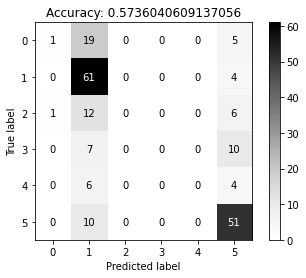

In [136]:
# testing --> ie. making predictions
yy_pred = NBC.predict(Xx_test)

# performance metric
accuracy = accuracy_score(yy_test, yy_pred)
print('The accuracy of this model is', round(accuracy*100, 2), '%')

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(yy_test, yy_pred) # define the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot it
plt.figure(figsize=(8, 6))
disp.plot(include_values=True, cmap=plt.cm.Greys) # black and white cause this is ancient? 
ax = disp.ax_
ax.set_title(f"Accuracy: {accuracy}") # title
plt.show()

On this extended dataset, the Naive Bayes achieves an accuracy of just 57.36 % compared to 85% accuracy on the smaller dataset of last time. 
The reduced accuracy of the Naive Bayes Classifier on the extended dataset compared to the smaller dataset from the first pipeline is most likely owing to the new dataset's greater complexity. With more data and more diverse messages from many family members and friends, the language and writing style utilized vary considerably, making it more difficult for the classifier to distinguish between the writers. Furthermore, there may be a class imbalance, with some writers having much more texts than others, making it more difficult for the classifier to correctly identify the authors who are underrepresented.
To account for the increasing complexity and variability in the data, more advanced techniques such as feature engineering or applying deep learning algorithms may be required to improve accuracy on the enlarged dataset. We can also try a different model to see how it compares to the Naive Bayes Classifier. 

## Model Selection (XGBoost)

XGBoost (eXtreme Gradient Boosting) is a robust implementation of the gradient boosting method. The gradient boosting approach constructs a decision tree ensemble in which each succeeding tree is trained to rectify the faults caused by the prior tree. This is accomplished by fitting each tree to the loss function's negative gradient with regard to the current model's predictions. XGBoost includes a number of enhancements and extra features that make it more efficient and adaptable.

The main components of the gradient boosting algorithm are:

- Loss function (objective function): A differentiable function that calculates the difference between true target values and model predictions. For classification tasks, common loss functions include logistic loss and multi-class log loss, whereas mean squared error and mean absolute error are used for regression tasks.

- Weak learners (base models): Decision trees are used as weak learners by the algorithm. These trees are often shallow (low in depth), with a high bias and a low variance. The idea is to integrate these weak learners in order to produce a strong learner with minimal bias and variation.

- Gradient boosting trains the weak learners sequentially, with each tree being added to the existing model to fix the errors made by the preceding trees. The final model is a linear combination of the trees, with each tree's contribution to the overall model weighted.


The math behind XGBoost involves:

- Computation of the gradient and Hessian of the loss function with respect to the predictions: At each step, it computes the gradient (first-order derivative) and Hessian (second-order derivative) of the loss function with regard to the predictions. These parameters guide the training of the next tree in the sequence to rectify errors caused by the previous tree.

- Regularization: In the objective function, XGBoost includes L1 (Lasso) and L2 (Ridge) regularization terms. By penalizing large weights in the tree ensemble, this helps regulate the model's complexity and prevents overfitting.

- Tree pruning: XGBoost controls the depth of the trees using a "max depth" parameter and applies an efficient algorithm for pruning trees based on the reduction in the loss function that each split gives. This contributes to less overfitting and simpler trees that generalize better.

XGBoost is especially quick since it supports parallelization, which allows the algorithm to generate many trees at the same time, reducing overall training time. It also supports distributed computation, which allows it to handle larger datasets by training on numerous machines.

**XGBoost Pseudocode**
1. initialize the model with a constant prediction value
2. For i in range(number of trees):
    - Compute the negative gradients and Hessian values of the loss function for each training example based on the current model's predictions.
    - Create a new decision tree by fitting it to the negative gradients and Hessian values.
3.  For leaf node in tree:
    - Compute the optimal weight for the leaf node by minimizing the regularized loss function.
4. Prune the tree if the gain in the loss function from a split is less than a predefined threshold.
5. Add the new tree to the model with a learning rate to control the contribution of the tree to the overall model.
6. Output the final model, which is a weighted combination of the decision trees.

From research, Naive Bayes Classifier is specifically designed for text classification whereas XGBoost is not. So how would these two models compare when given the same task? While XGBoost is not specifically designed for text classification we can still use it for this task for the following reasons:

- Handling sparse data: When text input is translated into numerical features using approaches such as TF-IDF or Bag of Words, the resulting data is frequently high-dimensional and sparse. XGBoost can handle sparse data successfully, making it excellent for text classification problems.

- XGBoost is an ensemble learning method, which means it combines the predictions of numerous weak learners (in this example, decision trees) to build a strong learner. By eliminating overfitting and capturing complicated patterns in the data, this method improves the model's performance and generalization capabilities.

- Regularization: The objective function of XGBoost includes L1 and L2 regularization terms. Regularization aids in model complexity control, preventing overfitting and enhancing generalization to previously unknown data. This is very handy when working with high-dimensional data, which is frequently the case in text classification.

- Text classification problems can occasionally be imbalanced, with some classes having much fewer samples than others. XGBoost allows you to provide different weights to distinct classes, which can help the model learn from imbalanced datasets more effectively.

- XGBoost is built for speed and can handle big datasets with millions of instances and thousands of features. This makes it suited for large-scale text classification jobs with a huge number of occurrences and features.

- Flexibility: XGBoost can be used with a variety of base learners (not only decision trees) and supports a wide range of loss functions. Because of this adaptability, you can modify the model to specific text classification tasks and objectives.

We can begin by installing the XGBoost into our Jupyter environment. 

In [94]:
# install XGBoost
!pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [99]:
# sanity check 
# Ensuring my data is still the same :) 
print('In this model selection stage I now have', len(texts_data), 'data points') 

# view first 5 data points of the data
texts_data.head(5) 

In this model selection stage I now have 982 data points


,text,label
0,sawa goodnight dear,mom
1,i went to the supermarket to buy some sufurias...,grandma
2,meanwhile do sth to cheer up,Lee
3,wa driving to see grandma just arrived,mom
4,yea it actually the simple thing in life that ...,mom


**Feature Engineering**

To use XGBoost for this classification task, we need to convert the text data that we have into a numerical format that can be used by the XGBoost Model. We can use BoW (Bag of Words) or TF-IDF (Term Frequency-Inverse Document Frequency) which is an extension of the BoW. In BoW we represent he text as a matrix where each row corresponds to a text data point and each column is a unique word found in the entire dataset. The values in the matrix are the frequency of the unique word in the text datapoint. This was achieved above using the "CountVectorizer" method 

In TF-IDF, the idea is the same, except this time, instead of using raw word frequencies, we weigh the word frequencies based on their importance in the datapoints and across the entire dataset. Words that are more unique or occur more frequently to a particular data point have higher weights. We can create a a TF-IDF representation using TfidfVectorizer from the sklearn.feature_extraction.text module as shown below. 

In [120]:
# Use TfidfVectorizer to create the feature matrix
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_data['text'])
y = texts_data['label']

X

<982x1470 sparse matrix of type '<class 'numpy.float64'>'
	with 4670 stored elements in Compressed Sparse Row format>

## Training the model

After encoding the data, the next step is to split the data into the training set which trains the model and the testing set which evaluates the performance of the model. We also need to convert the string labels into interger-encoded labels that we pass into the model. Otherwise, this throws off an error. 

In [125]:
# Convert the string labels into integer-encoded labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

len(y_train) # Sanity Check

785

In [127]:
# Train the XGBoost classifier

xgbs = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgbs.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

## Predictions and performance metrics.

We can now use the test data to examine how the model performs on unseen data, which in this case is the X_test data, after we have trained it. We can assess the model's performance using metrics such as accuracy which is the fraction of correct predictions (including true positives and true negatives) across all instances.

Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [137]:
# Make predictions on the test set
y_pred = xgbs.predict(X_test)

# Convert the integer-encoded predictions back to string labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate the classifier's performance
accuracyXGB = accuracy_score(y_test, y_pred)
print('The accuracy of the XGBoost model is',  round(accuracyXGB*100, 2), '%')

The accuracy of the XGBoost model is 47.72 %


## Visualizing results and Conclusions.

We can display the confusion matrix alongside the accuracy score

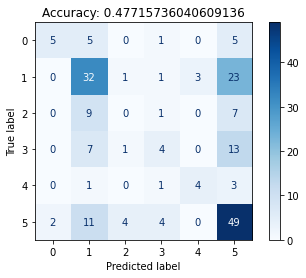

In [135]:
cm2 = confusion_matrix(y_test, y_pred) # define the confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)

# Plot confusion matrix
disp2.plot(include_values=True, cmap=plt.cm.Blues) #nice color? 
ax = disp2.ax_
ax.set_title(f"Accuracy: {accuracyXGB}") # title
plt.show()

From our results we can see that the XGBoost does not perform as well as the Naive Bayes Classifier on text classification. For the same dataset, the Naive Bayes classifier has an accuracy score of approximately 57% while the XGBoost has a score of approximately 47%.

## So why does XGBoost do so badly on text classification and why does the Naive Bayes perform worse on more data? 

**XGBoost:** XGBoost is a gradient boosting method that performs well on tabular data with numerous features and is excellent at handling structured data. However, it is not intended for text categorization jobs. The fundamental reason is because XGBoost is based on decision trees, which are unsuitable for dealing with the large dimensionality and sparsity of text data. Text data is often translated into a bag-of-words or TF-IDF representation, resulting in an extremely sparse and high-dimensional matrix. While XGBoost can still be used for text classification problems, it may fail to outperform competing algorithms created expressly for this domain, such as Naive Bayes or deep learning models like recurrent neural networks (RNNs) and transformers.


**Naive Bayes:** Naive Bayes is a probabilistic classifier that performs well for binary and multi-class text classification problems, particularly when the dataset is small or medium-sized. It is based on the Bayes theorem and assumes that given the class, the features (words) in the text are conditionally independent. The "naive" assumption provides for efficient computing but may not hold true in actuality. As a result, Naive Bayes may occasionally underperform on multiple classification problems, particularly when the number of classes increases, class boundaries get more complex, or the independence condition is violated to a greater extent. Despite its simplicity, Naive Bayes may produce competitive results in a wide range of text categorization applications.

## Executive Summary

**Introduction:**

Natural language processing relies heavily on text classification, which has applications ranging from sentiment analysis to spam detection. In this pipeline, I examine the problem of text message classification depending on the sender. After cleaning, the dataset contains 982 messages from six different senders: mom, dad, grandma, Rasugu, Irynn, and Lee. My goal is to create a model that accurately predicts who sent a text message. To analyze their accuracy in this specific classification task, I examine the performance of two frequently used algorithms, Nave Bayes Classifier and XGBoost.

**Method:**

- Data Preprocessing: I first preprocess the text data, which includes tokenizing the messages, stemming the words, and removing stop words.

- Feature Extraction: I create a Bag of Words representation using the CountVectorizer method from the scikit-learn library for the Naïve Bayes Classifier. For the XGBoost algorithm, I use a Term Frequency-Inverse Document Frequency (TF-IDF) representation of the text data.

- Model Implementation and Evaluation:

    a. Naïve Bayes Classifier: I implement a Naïve Bayes Classifier and evaluate its performance using a stratified 5-fold cross-validation approach. I then train the final model on the entire training dataset and test its performance on an unseen test dataset.
    
    b. XGBoost: I train an XGBoost classifier using the TF-IDF representation of the dataset and evaluate its performance on the test dataset.

**Conclusion:**

My results indicate that, in this specific text classification task, the Naïve Bayes Classifier performs better, achieving an accuracy of 57.36% on the test dataset, compared to the 47.72% accuracy of the XGBoost model. It is important to note that the performance of both models may be improved through further feature engineering, hyperparameter tuning, and exploring alternative text representation techniques. We can also try different models that are more suitable for text classification such as support vector machines (SVM), logistic regression or deep learning models. 

## References

(n.d.). NLTK :: Natural Language Toolkit. https://www.nltk.org/

(2022, February 20). Business News Live, Share Market News - Read Latest Finance News, IPO, Mutual Funds News. https://economictimes.indiatimes.com/defaultinterstitial.cms

Burchfiel, A. (2022, May 16). What is NLP (Natural Language Processing) Tokenization? - tokenex. TokenEx. https://www.tokenex.com/blog/ab-what-is-nlp-natural-language-processing-tokenization/

Chen, T., & Guestrin, C. (2016, June 10). XGBoost: A Scalable Tree Boosting System. https://arxiv.org/pdf/1603.02754.pdf

Hayes, A. (2022, March 1). Bayes' Theorem: What It Is, the Formula, and Examples. Investopedia. https://www.investopedia.com/terms/b/bayes-theorem.asp

Introduction to Boosted Trees — xgboost 1.7.5 documentation. (n.d.). XGBoost Documentation. https://xgboost.readthedocs.io/en/stable/tutorials/model.html

Matibe, M. (2023, February 17). First Pipeline. CS156: Finding Patterns in Data with Machine Learning.

Naive Bayes classifier. (n.d.). Wikipedia. https://en.wikipedia.org/wiki/Naive_Bayes_classifier

Starmer, J. (2019, December 16). XGBoost Part 1 (of 4): Regression. YouTube. https://www.youtube.com/watch?v=OtD8wVaFm6E
